In [1]:
import wrds, pandas as pd
db = wrds.Connection()
start, end = "2000-01-01", "2025-09-24"

cols = db.get_table('crsp', 'dsf', obs=0).columns
ex_col = 'hexcd' if 'hexcd' in cols else 'exchcd'
sh_col = 'shrcd' if 'shrcd' in cols else ('hshrcd' if 'hshrcd' in cols else None)

where_sh = f"AND {sh_col} IN (10,11)" if sh_col else ""  # fallback if neither exists

sql = f"""
    SELECT date,
           CASE WHEN {ex_col}=1 THEN 'NYSE'
                WHEN {ex_col}=3 THEN 'NASDAQ' END AS exchange,
           SUM(vol) AS sh_volume
    FROM crsp.dsf
    WHERE date BETWEEN '{start}' AND '{end}'
      AND {ex_col} IN (1,3)
      {where_sh}
      AND vol >= 0
    GROUP BY date, exchange
    ORDER BY date, exchange;
"""
vol_df = db.raw_sql(sql, date_cols=['date'])


WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
# Split by exchange
nyse_df   = vol_df[vol_df['exchange'] == 'NYSE'].copy()
nasdaq_df = vol_df[vol_df['exchange'] == 'NASDAQ'].copy()

# Save to CSV
nyse_df.to_csv("crsp_daily_volume_nyse.csv", index=False)
nasdaq_df.to_csv("crsp_daily_volume_nasdaq.csv", index=False)


In [3]:
# Sum volumes across exchanges for each date
vol_df = (
    vol_df.groupby('date', as_index=False)['sh_volume']
    .sum()
)

vol_df.to_csv("crsp_daily_volume_all.csv", index=False)

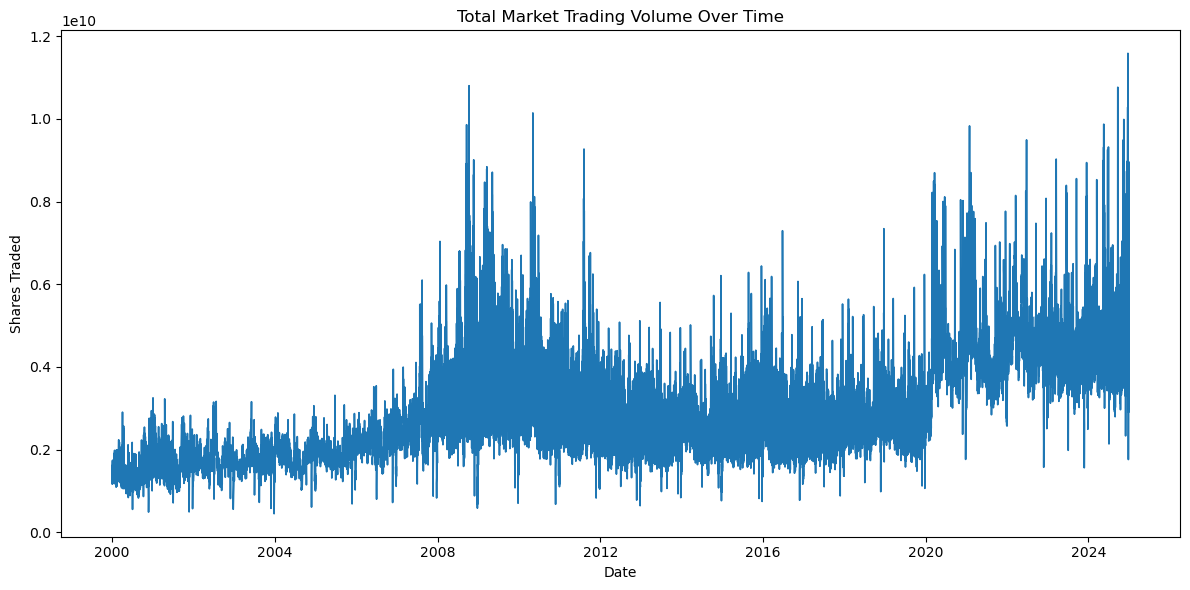

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(vol_df["date"], vol_df["sh_volume"], linewidth=1.2)
plt.title("Total Market Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Shares Traded")
plt.tight_layout()
plt.show()


In [3]:
count_high_volume = (vol_df["sh_volume"] > 1.0e10).sum()
print("Days with total volume > 10 billion shares:", count_high_volume)


Days with total volume > 10 billion shares: 5
